# Synthefy Forecasting API: A Comprehensive Guide

Welcome to the Synthefy Forecasting API! This notebook demonstrates how to use our powerful forecasting capabilities to predict time series data with advanced features like context-aware forecasting and external data integration.

## What is Synthefy?

Synthefy is an advanced forecasting API that leverages foundation models to provide accurate predictions for your time series data. Our API offers:

- **Simple Integration**: Easy-to-use Python interface
- **Context-Aware Forecasting**: Incorporate future known data into your predictions
- **External Data Integration**: Leverage Haver Analytics data for enhanced predictions
- **Flexible Input**: Support for multiple targets and covariates

## Getting Started

First, let's set up our environment and import the necessary libraries.


In [ ]:
import json
from typing import Any, Dict, List, Optional, Tuple

import httpx
import pandas as pd
from pydantic import BaseModel, Field, field_validator
import matplotlib.pyplot as plt
import shap
import numpy as np

# --------------------------------------------------- Setup API ---------------------------------------------------
X_API_KEY = "XXXX-XXXX"  # Replace with your API key
BASE_URL = "https://prod.synthefy.com"
client = httpx.Client(base_url=BASE_URL, timeout=120.0) # High timeoutfor SHAP analysis
ENDPOINT = "api/foundation_models/forecast/stream"

# --------------------------------------------------- End API Setup ---------------------------------------------------

# ## Understanding the Data Models
#
# Our API uses Pydantic models to ensure data validation and type safety. Let's explore the key components:


# --------------------------------------------------- Data Model(s) ---------------------------------------------------

class FoundationModelForecastStreamRequest(BaseModel):
    # --------------- User uploaded data ---------------
    historical_timestamps: List[str]

    # from df.to_dict(orient='list')
    historical_timeseries_data: Dict[str, List[Any]]
    targets: List[str]  # must be present as keys in historical_timeseries_data

    # must be present in historical_timeseries_data if provided
    covariates: List[str] = Field(default_factory=list)
    # --------------- End user uploaded data ---------------

    # --------------- Synthefy Database context ---------------
    synthefy_metadata_info_combined: None # Unused
    synthefy_metadata_leak_idxs: Optional[List[int]] = None # Unused
    # --------------- End Synthefy Database context ---------------

    # --------------- Data for Forecasting ---------------
    # the timestamps for which we want to predict the targets' values
    forecast_timestamps: List[str]
    # from df.to_dict(orient='list'); future metadata that will be used
    future_timeseries_data: Dict[str, List[Any]] | None
    # --------------- End Data for Forecasting ---------------

    # Dict used to add constant context (will be same for each timestamp/repeated for the dfs)
    static_context: Dict[str, float | int | str] | None
    prompt: str | None  # Prompt/description of the task/data/etc

    quantiles: List[float] | None  # which quantiles to return
    do_shap_analysis: bool = False



def make_api_call(request: FoundationModelForecastStreamRequest):
# Make the API call
    response = client.post(
        ENDPOINT,
        json=request.model_dump(),
        headers={"X-API-Key": X_API_KEY},
    )
    return response


# ## Helper Functions
#
# We provide a comprehensive helper function to convert your data into the format our API expects:


def convert_df_to_synthefy_request(
    df: pd.DataFrame,
    future_df: pd.DataFrame | None,
    target_cols: List[str],
    forecast_timestamps: List[str],
    timestamp_col: Optional[str] = None,  # auto-detect if not provided
    covariate_cols: List[str] = [],
    do_shap_analysis: bool = False,
) -> FoundationModelForecastStreamRequest:
    """Convert pandas DataFrames into a Synthefy API request.

    This function handles all the data preparation needed to make a forecast request.
    It supports:
    - Automatic timestamp detection
    - Multiple target variables
    - Optional covariates
    - Future known data
    - External data integration

    Args:
        df: Historical data DataFrame
        future_df: Future known data DataFrame (can be empty)
        target_cols: Columns to forecast
        forecast_timestamps: Timestamps to forecast for
        timestamp_col: Column containing timestamps (auto-detected if None)
        covariate_cols: Additional columns to use as features
        synthefy_metadata_info_combined: External data sources to use
        synthefy_metadata_leak_idxs: Which external data sources to use

    Returns:
        A properly formatted request object for the Synthefy API
    """
    df_copy = df.copy()
    # auto-detect timestamp column if not provided
    if timestamp_col is None:
        for col in df.columns:
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                timestamp_col = col
                break
    else:
        df.loc[:, timestamp_col] = pd.to_datetime(df[timestamp_col])
        if future_df is not None:
            future_df.loc[:, timestamp_col] = pd.to_datetime(
                future_df[timestamp_col]
            )
    if not timestamp_col:
        raise ValueError("No timestamp column found")

    historical_timestamps = [
        ts.isoformat() for ts in df[timestamp_col].tolist()
    ]

    # drop timestamp column from df
    df_copy = df_copy.drop(columns=[timestamp_col])

    df_copy = df_copy[target_cols + covariate_cols]
    historical_timeseries_data = df_copy.to_dict(orient="list")
    historical_timeseries_data = {
        str(k): v for k, v in historical_timeseries_data.items()
    }

    # Get the future_timeseries_data (don't give the target columns)
    future_timeseries_data = None
    if future_df is not None:
        future_timeseries_data = future_df[covariate_cols].to_dict(
            orient="list"
        )
        future_timeseries_data = {
            str(k): v for k, v in future_timeseries_data.items()
        }

    # create request object
    request = FoundationModelForecastStreamRequest(
        historical_timestamps=historical_timestamps,
        historical_timeseries_data=historical_timeseries_data,
        targets=target_cols,
        covariates=covariate_cols,
        synthefy_metadata_info_combined=None,
        synthefy_metadata_leak_idxs=None,
        forecast_timestamps=forecast_timestamps,
        future_timeseries_data=future_timeseries_data,
        static_context=None,  # Not yet supported
        prompt=None,  # Not yet supported
        quantiles=None,
        do_shap_analysis=do_shap_analysis,
    )

    return request

def convert_response_to_df(
    response: Dict[str, Any],
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Any] | None]:
    """Convert API response to pandas DataFrames for easy analysis.

    Args:
        response: The API response dictionary

    Returns:
        Tuple of (forecast_df, quantiles_df) where:
        - forecast_df contains the point forecasts
        - quantiles_df contains the forecast quantiles
    """
    forecast_dict = {k: v for k, v in response["forecast"].items()}
    quantiles = {k: v for k, v in response["forecast_quantiles"].items()}
    forecast_df = pd.DataFrame(forecast_dict)
    forecast_df["timestamp"] = pd.to_datetime(response["forecast_timestamps"])
    quantiles_df = pd.DataFrame(quantiles)
    quantiles_df["timestamp"] = pd.to_datetime(response["forecast_timestamps"])
    if response.get("warnings"):
        print(response.get("warnings"))
    return forecast_df, quantiles_df, response.get("shap_analysis", None)



/home/raimi/synthefy-package/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./walmart_sales.csv")
df


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,store_1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,store_1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,store_1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,store_1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,store_1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,store_45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,store_45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,store_45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,store_45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


In [3]:
# The last date is 2012-10-26. -> Let's forecast for the next 4 weeks.
df = df[df["Store"] == "store_1"]

# Create a basic forecast request
request = convert_df_to_synthefy_request(
    df=df,
    future_df=None,  # No future data in this example
    target_cols=["Weekly_Sales"],
    forecast_timestamps=[
        "2012-11-02",
        "2012-11-09",
        "2012-11-16",
        "2012-11-23",
    ],
    timestamp_col="Date",
    covariate_cols=[],
)

In [4]:
# Let's examine our request
print(json.dumps(request.model_dump(), indent=4))


{
    "historical_timestamps": [
        "2010-02-05T00:00:00",
        "2010-02-12T00:00:00",
        "2010-02-19T00:00:00",
        "2010-02-26T00:00:00",
        "2010-03-05T00:00:00",
        "2010-03-12T00:00:00",
        "2010-03-19T00:00:00",
        "2010-03-26T00:00:00",
        "2010-04-02T00:00:00",
        "2010-04-09T00:00:00",
        "2010-04-16T00:00:00",
        "2010-04-23T00:00:00",
        "2010-04-30T00:00:00",
        "2010-05-07T00:00:00",
        "2010-05-14T00:00:00",
        "2010-05-21T00:00:00",
        "2010-05-28T00:00:00",
        "2010-06-04T00:00:00",
        "2010-06-11T00:00:00",
        "2010-06-18T00:00:00",
        "2010-06-25T00:00:00",
        "2010-07-02T00:00:00",
        "2010-07-09T00:00:00",
        "2010-07-16T00:00:00",
        "2010-07-23T00:00:00",
        "2010-07-30T00:00:00",
        "2010-08-06T00:00:00",
        "2010-08-13T00:00:00",
        "2010-08-20T00:00:00",
        "2010-08-27T00:00:00",
        "2010-09-03T00:00:00",
      

In [5]:
# Make the API call
response = make_api_call(request)

# Convert response to DataFrames for analysis
forecast_df, quantiles_df, _ = convert_response_to_df(response.json())


In [6]:
print("Point Forecasts:")
forecast_df


Point Forecasts:


,Weekly_Sales,timestamp
0,1647802.125,2012-11-02
1,1693052.750,2012-11-09
2,1675161.875,2012-11-16
3,2051584.500,2012-11-23


In [7]:
print("Forecast Quantiles:")
quantiles_df


Forecast Quantiles:


,Weekly_Sales_p10,Weekly_Sales_p90,timestamp
0,1573187.50,1753849.375,2012-11-02
1,1616396.75,1814213.125,2012-11-09
2,1569533.75,1844631.500,2012-11-16
3,1643169.50,2317057.750,2012-11-23


## Example 2: Using Future Known Data

Now, let's enhance our forecast by incorporating known future data. This is useful when you have
information about future events that might affect your target variable.


In [8]:
# Split our data into historical and future portions
historical_df = df[df["Date"] < pd.Timestamp("2012-09-01")]
future_df = df[df["Date"] >= pd.Timestamp("2012-09-01")]
print(historical_df.tail(2))
print(future_df.head(2))

# Create a request with future known data
request = convert_df_to_synthefy_request(
    df=historical_df,
    future_df=future_df,
    target_cols=["Weekly_Sales", "Unemployment"],
    forecast_timestamps=[ts.isoformat() for ts in future_df["Date"].tolist()],
    timestamp_col="Date",
    covariate_cols=["Holiday_Flag", "CPI"],
)


       Store                 Date  Weekly_Sales  Holiday_Flag  Temperature  \
133  store_1  2012-08-24 00:00:00    1494122.38             0        77.66   
134  store_1  2012-08-31 00:00:00    1582083.40             0        80.49   

     Fuel_Price         CPI  Unemployment  
133       3.620  222.171946         6.908  
134       3.638  222.305480         6.908  
       Store                 Date  Weekly_Sales  Holiday_Flag  Temperature  \
135  store_1  2012-09-07 00:00:00    1661767.33             1        83.96   
136  store_1  2012-09-14 00:00:00    1517428.87             0        74.97   

     Fuel_Price         CPI  Unemployment  
135       3.730  222.439015         6.908  
136       3.717  222.582019         6.908  


In [9]:
# Make the API call
response = make_api_call(request)

# Convert response to DataFrames for analysis
forecast_df, quantiles_df, _ = convert_response_to_df(response.json())

In [10]:
print("Point Forecasts:")
forecast_df

Point Forecasts:


,Weekly_Sales,Unemployment,timestamp
0,1697373.750,6.904366,2012-09-07
1,1574735.000,6.902851,2012-09-14
2,1503205.250,6.902923,2012-09-21
3,1474757.125,6.903275,2012-09-28
4,1708432.500,6.913973,2012-10-05
5,1612709.000,6.915305,2012-10-12
6,1570907.000,6.916039,2012-10-19
7,1509979.250,6.915297,2012-10-26


In [11]:
print("Forecast Quantiles:")
quantiles_df


Forecast Quantiles:


,Weekly_Sales_p10,Weekly_Sales_p90,Unemployment_p10,Unemployment_p90,timestamp
0,1598435.375,1835137.625,6.882983,6.941525,2012-09-07
1,1511026.875,1652686.375,6.879889,6.935410,2012-09-14
2,1432771.000,1573542.375,6.877739,7.037675,2012-09-21
3,1406601.625,1564865.875,6.874552,7.103504,2012-09-28
4,1607743.125,1835354.500,6.869568,7.174543,2012-10-05
5,1536575.500,1728843.000,6.868763,7.184857,2012-10-12
6,1487009.375,1688803.625,6.866201,7.193079,2012-10-19
7,1431296.625,1659863.500,6.863100,7.206848,2012-10-26


## Interpretability - Shap 

Let's look at the features that influence the output. We'll forecast over the holiday period (Thanksgiving, Christmas, New Years) to observe the important features.

In [12]:
# Use the same data as the previous section, but forecast for the next 10 weeks

request = convert_df_to_synthefy_request(
    df=historical_df,
    future_df=future_df,
    target_cols=["Weekly_Sales"], # Just use 1 target for SHAP analysis
    forecast_timestamps=[
        "2012-11-02",
        "2012-11-09",
        "2012-11-16",
        "2012-11-23",
        "2012-11-30",
        "2012-12-07",
        "2012-12-14",
        "2012-12-21",
        "2012-12-28",
        "2013-01-04",
    ],
    timestamp_col="Date",
    covariate_cols=["Holiday_Flag", "CPI", "Unemployment"],
    do_shap_analysis=True,
)
response = make_api_call(request)

forecast_df, quantiles_df, shap_analysis = convert_response_to_df(response.json())

['⚠️ SHAP analysis is enabled. This will significantly increase processing time and may take several minutes to complete. Please be patient while the analysis runs. Note: Results may degrade if there are 5 or more covariates. Contact the Synthefy team for optimal performance with complex datasets.']


In [13]:
shap_analysis

{'Weekly_Sales': {'Weekly_Sales_features': [68811.70150446083,
   67518.04466749783,
   67872.09593254664,
   41960.72951157811,
   60957.086368176635,
   73319.3974585748,
   60637.200554081435,
   20536.532647156415,
   0.0,
   0.0],
  'Unemployment': [25268.080080808813,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   2917.7360441906203,
   0.0,
   7170.705296711474,
   0.0],
  'Holiday_Flag': [1904.472554282793,
   0.0,
   0.0,
   6451.880448749929,
   3707.543352503184,
   0.0,
   0.0,
   8336.104622599916,
   0.0,
   1950.1941751343527],
  'CPI': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}}

Creating SHAP beeswarm plots for each target...


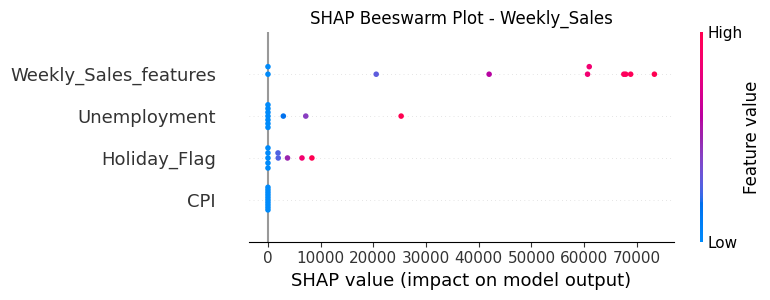


SHAP Values Summary:

Weekly_Sales:
  Weekly_Sales_features: Mean |SHAP| = 46161.2789
  Unemployment: Mean |SHAP| = 3535.6521
  Holiday_Flag: Mean |SHAP| = 2235.0195
  CPI: Mean |SHAP| = 0.0000


In [14]:
def plot_shap_beeswarm_from_response(request, shap_analysis):
    """
    Plots SHAP beeswarm plots for each target in the SHAP analysis response.
    Also prints a summary of mean absolute SHAP values for each feature.

    Args:
        request: The original Synthefy request object (not used in plotting, but included for API consistency).
        shap_analysis: The SHAP analysis dictionary from the Synthefy API response.
    """
    # The SHAP analysis has this structure:
    # {target_name: {feature_name: [shap_values_list], ...}, ...}

    print("Creating SHAP beeswarm plots for each target...")

    # Create a subplot for each target variable
    targets = list(shap_analysis.keys())
    fig, axes = plt.subplots(len(targets), 1, figsize=(12, 6 * len(targets)))

    # Handle case where there's only one target (axes won't be a list)
    if len(targets) == 1:
        axes = [axes]

    for idx, target in enumerate(targets):
        target_data = shap_analysis[target]

        # Extract feature names and SHAP values
        feature_names = list(target_data.keys())

        # Get the length of SHAP values (number of forecast points)
        n_samples = len(list(target_data.values())[0])

        # Organize SHAP values: each row is a sample, each column is a feature
        shap_matrix = np.zeros((n_samples, len(feature_names)))

        for feat_idx, feature_name in enumerate(feature_names):
            shap_values = target_data[feature_name]
            shap_matrix[:, feat_idx] = shap_values

        # Create a simple feature value matrix (we don't have actual feature values,
        # so we'll use the SHAP values themselves for coloring)
        feature_values = shap_matrix.copy()

        # Create SHAP explanation object
        explanation = shap.Explanation(
            values=shap_matrix,
            data=feature_values,
            feature_names=feature_names
        )

        # Create beeswarm plot for this target
        plt.sca(axes[idx])
        shap.plots.beeswarm(explanation, show=False, max_display=len(feature_names))
        plt.title(f"SHAP Beeswarm Plot - {target}")

    plt.tight_layout()
    plt.show()

    # Also create a summary of SHAP values
    print("\nSHAP Values Summary:")
    for target in targets:
        print(f"\n{target}:")
        target_data = shap_analysis[target]
        for feature_name, shap_values in target_data.items():
            mean_abs_shap = np.mean(np.abs(shap_values))
            print(f"  {feature_name}: Mean |SHAP| = {mean_abs_shap:.4f}")

plot_shap_beeswarm_from_response(request, shap_analysis)


## Next Steps
Now that you've seen the basics of using the Synthefy Forecasting API, you can:
1. Try different combinations of targets and covariates
2. Experiment with different external data sources
3. Adjust the forecast horizon
